# Team Project 3
Members:

Neal Fennimore - nf2137

Nathan Vulakh - nv2155

Mike Dela Calzada - md5286

Miri Alair - mg6931

# Problem 1 

> This is not a code exercise. Students do it manually.

Let 𝐸 be a block cipher of block length 4 that .

a) The following table is used to convert (or encode) an English plaintext into a bit string.

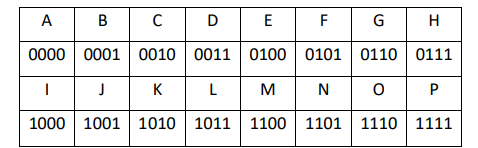

b) Given a plaintext message p = ‘FOO’, encrypt it manually using the following operation modes:
1) ECB, 2) CBC mode with IV = 1010, 3) CTR mode with ctr = 1010. Make sure you have the final ciphertexts in letters that are easy to transmit to the receiver.

ECB - 
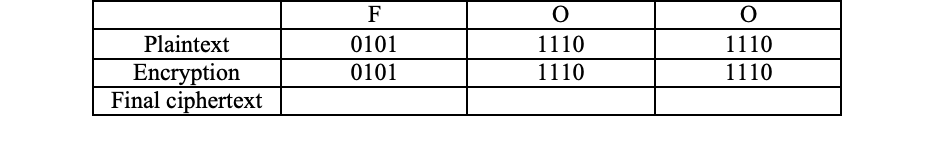

CBC mode with IV = 1010
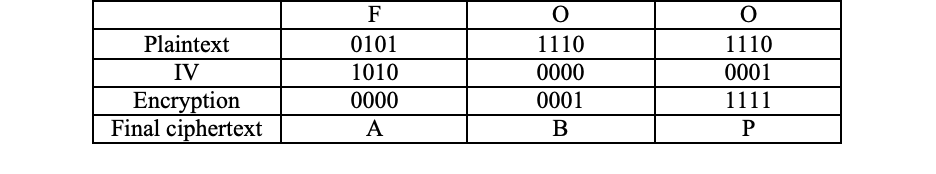

CTR mode with ctr = 1010
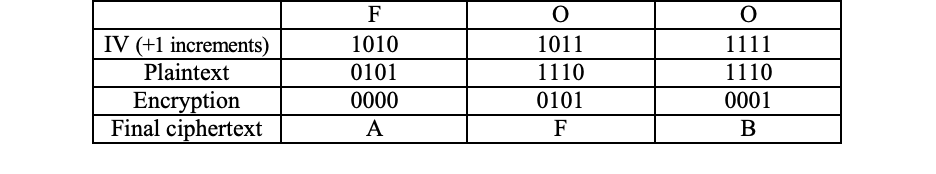

c) The receiver received the ciphertexts in letters and decrypted them, respectively.


# Problem 2

> This is a python code exercise to implement the so called “Meet-in-the-Middle Attack”
(https://en.wikipedia.org/wiki/Meet-in-the-middle_attack ).


It is a cryptanalytic attack applicable to ciphers based on composition of multiple rounds of substitutions
and permutations. It works by finding plaintext-ciphertext pairs that map to the same intermediate
value after partial encryption/decryption. We can perform an exhaustive search on a simplified cipher
by splitting the secret key into independent parts.

We are going to use the simplified AES (SAES). The class slides give the details of SAES. It starts with key
expansion, then works on encryption to get ciphertext and on decryption to recover the plaintext. The
key expansion generates three keys. It has 2 rounds.

The first key, Key0, is used for the add round key to the plaintext.

The second key, Key1, is used to perform Round 1 transformation on state, defined as encrypt_round1()

The third key, Key2, is used to perform Round 2 transformations on state, defined as encrypt_round2()

For the decryption,

Key2 is used to perform inverse Round 2 transformations on ciphertext, defined as decrypt_round2()

Key1 is used to perform inverse Round 1 transformations on state, defined as decrypt_round1()

Key0 is to do add round key.

So, the pseudo-code would be:
1. Get (Key0, Key1, Key2) from Key K using the key expansion.
2. Encrypt a plaintext to get the ciphertext.
3. Assume we can get Key0 easily. So we do not worry the initial add-round key operation. And we
can assume the first round start with the plaintext.
4. Partially encrypt the plaintext with just Key1 to get intermediate state.
5. Partially decrypt ciphertext with just Key2 to get intermediate state.
6. Compare intermediate states to find matching Key1 and Key2


The base utility functions are well defined. Students shall be able to implement them. It is also fine if students use existing code somewhere. They need to credit the source.


**Code guideline (exhaustive search):**

a) Implement the simplified AES.

b) Write functions to partially encrypt plaintext with just the first round key and partially decrypt ciphertext with just the last round key.

c) Execute an exhaustive search to generate all possible first and last round keys.

d) Match the intermediate states from partial encryption and decryption to find plaintextciphertext pairs that reveal the round keys.

e) Given a plaintext-ciphertext pair encrypted with the full key, use the attack to recover the simplified round keys.








**Test Scenario 1**

> Select key size = 16, the block size =16. This is the typical case on the simplified AES as
explained in the slides. It is easy to get the possible key space is 2^16 = 65536. The match two keys using
exhausted method would be 65536x65536 = 4,294,967,296. Clearly, your testing machine needs to be
powerful. If you cannot get the results fast enough, summarize it and move to the test scenario 2. That
is the nature of cryptoanalysis.

**Test Scenario 2**

> Select key size = 8, the block size =8. This is the reduced simplified AES (rSAES). In this
case, the possible key space is 2^8 = 256. The match two keys using exhausted method would be 256x256
= 65536, a huge reduction in test cases. And it should be manageable.

But we need to work on the 2x2 matrix with each element having 2 bits. Let me define the four
functions, add_round_key, shift_row, sub_2bit and mixed_column. Note, this is for academic purposes
only. I am not aware any of such rSAES existed. Here we use the GF(2^2
) with m(x) = 𝑥² + 𝑥 + 1.

Add_round_key – bit wise XOR

Shift_row: shift the second row one positon.

Sub_2bit: Using the similar formula from AES, we define A =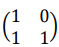 and b =, and the sub is defined as (Aa^-1)+b. My calculation gives the S_table 

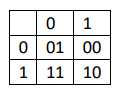

Mix_column: define M =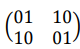, the mixed column Mc where c =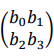. We can get the substitution.

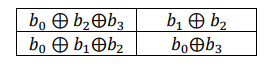


Answer the following questions.

1. Make sure you have the code for test scenario 1 and the code for test scenario 2 as well.

2. Answer if you can find the matched keys in test scenario 2, or both? You can use a driver call to test your codes. The Cas have their own test cases.

3. Analyze the time and memory complexity of the attack.

4. Discuss how increasing the number of rounds exponentially increases the difficulty of the attack.


In [288]:
from typing import List, Tuple, Optional, Iterator

sbox = bytearray([
    0x9, 0x4, 0xa, 0xb,
    0xd, 0x1, 0x8, 0x5,
    0x6, 0x2, 0x0, 0x3,
    0xc, 0xe, 0xf, 0x7
])
 
inverse_sbox = bytearray([
    0xa, 0x5, 0x9, 0xb,
    0x1, 0x7, 0x8, 0xf,
    0x6, 0x0, 0x2, 0x3,
    0xc, 0x4, 0xd, 0xe
])

class Nibble(int):
    def __init__(self, _, **kwargs):
        assert self <= 15

class Byte(int):
    def __init__(self, _, **kwargs):
        assert self <= 255

    def to_nibbles(self):
        return [Nibble(self >> 4), Nibble(self & 0xF)]

class Word(int):
    def __init__(self, _, **kwargs):
        assert self <= 65535

    def to_bytes(self):
        return [Byte(self >> 8), Byte(self & 0xFF)]
    
    def to_nibbles(self):
        return [nibble for b in self.to_bytes() for nibble in b.to_nibbles()]
    
    def swap_nibbles(self, a: int, b: int):
        nibbles = self.to_nibbles()
        nibbles[a], nibbles[b] = nibbles[b], nibbles[a]
        return Word.from_nibbles(nibbles)
    
    @staticmethod
    def from_nibbles(n: List[Nibble] | List[int]):
        return Word((n[0] << 12) + (n[1] << 8) + (n[2] << 4) + n[3])

w = Word(65535)
assert w.to_nibbles() == [15,15,15,15]
assert w.to_bytes() == [255, 255]
assert w == Word.from_nibbles(w.to_nibbles())

class Key(Word):
    pass

Keys = Tuple[Key, Key, Key]

class KeyGen:
    def __init__(self, K: Word, sbox: bytearray):
        self.K = K
        self.sbox = sbox

    def gen(self) -> Keys:
        r0, r1 = 0x80, 0x30

        w0, w1 = self.K.to_bytes()
        w2 = w0 ^ r0 ^ self.substitute(w1)
        w3 = w2 ^ w1
        w4 = w2 ^ r1 ^ self.substitute(Byte(w3))
        w5 = w4 ^ w3

        k0 = (w0 << 8) + w1
        k1 = (w2 << 8) + w3
        k2 = (w4 << 8) + w5

        return Key(k0), Key(k1), Key(k2)

    def substitute(self, w: Byte):
        high, low = w.to_nibbles()
        return self.sbox[high] + (self.sbox[low] << 4)

K = Word(0x4AF5)
k0, k1, k2 = KeyGen(K, sbox).gen()
assert KeyGen(K, sbox).gen() == (0x4AF5, 0xDD28, 0x87AF)

class SAES:
    sbox: bytearray = sbox
    inverse_sbox: bytearray = inverse_sbox

    @staticmethod
    # From https://jhafranco.com/2012/02/11/simplified-aes-implementation-in-python/
    def GF(p1: int, p2: int):
        """Multiply two polynomials in GF(2^4)/x^4 + x + 1"""
        p = 0
        while p2:
            if p2 & 0b1:
                p ^= p1
            p1 <<= 1
            if p1 & 0b10000:
                p1 ^= 0b11
            p2 >>= 1
        return p & 0b1111

    def encrypt_gen(self, P: int, K: int) -> Iterator[Word]:
        def mix_columns(w: Word):
            n = w.to_nibbles()
            return Word.from_nibbles([
                n[0] ^ SAES.GF(4, n[1]),
                n[1] ^ SAES.GF(4, n[0]),
                n[2] ^ SAES.GF(4, n[3]),
                n[3] ^ SAES.GF(4, n[2])
            ])


        k0, k1, k2 = KeyGen(Word(K), self.sbox).gen()

        # Round 1
        s = Word(P ^ k0)
        yield s

        # Round 2
        s = Word.from_nibbles([
            self.sbox[i] for i in s.to_nibbles()
        ])
        s = s.swap_nibbles(1, 3)
        s = mix_columns(s)
        s = Word(s ^ k1)
        yield s

        # Round 3
        s = Word.from_nibbles([
            self.sbox[i] for i in s.to_nibbles()
        ])
        s = s.swap_nibbles(1, 3)
        yield Word(s ^ k2)

    def encrypt(self, P: int, K: int, rounds: int = 3) -> Word:
        assert rounds <= 3 and rounds > 0
        gen = self.encrypt_gen(P, K)
        result: Optional[Word] = None
        for _ in range(rounds):
            result = next(gen)
        assert result is not None
        return result

    def decrypt_gen(self, C: int, K: int) -> Iterator[Word]:
        def inverse_mix_columns(w: Word):
            n = w.to_nibbles()
            return Word.from_nibbles([
                SAES.GF(9, n[0]) ^ SAES.GF(2, n[1]),
                SAES.GF(9, n[1]) ^ SAES.GF(2, n[0]),
                SAES.GF(9, n[2]) ^ SAES.GF(2, n[3]),
                SAES.GF(9, n[3]) ^ SAES.GF(2, n[2])
            ])
     
        k0, k1, k2 = KeyGen(Word(K), self.sbox).gen()

        # Round 1
        s = Word(C ^ k2)
        s = s.swap_nibbles(1, 3)
        s = Word.from_nibbles([
            self.inverse_sbox[i] for i in s.to_nibbles()
        ])
        yield s

        # Round 2
        s = Word(s ^ k1)
        s = inverse_mix_columns(s)
        s = s.swap_nibbles(1, 3)
        s = Word.from_nibbles([
            self.inverse_sbox[i] for i in s.to_nibbles()
        ])
        yield s

        # Round 3
        yield Word(s ^ k0)

    def decrypt(self, C: int, K: int, rounds: int = 3) -> Word:
        assert rounds <= 3 and rounds > 0
        gen = self.decrypt_gen(C, K)
        result: Optional[Word] = None
        for _ in range(rounds):
            result = next(gen)
        assert result is not None
        return result

# Test cases from https://sandilands.info/sgordon/teaching/reports/simplified-aes-example.pdf
K = 0x4AF5
P = 0xD728
saes = SAES()
C = saes.encrypt(P, K)
assert saes.encrypt(P, K) == 0x24EC
assert saes.decrypt(C, K) == P

for P in range(65356):
    assert saes.decrypt(saes.encrypt(P, K), K) == P